<a href="https://colab.research.google.com/github/ishgirwan/omdena_hdi/blob/master/export_raster_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
!pip install geopandas
!pip install rasterio
!pip install geemap

In [4]:
import numpy as np
import geopandas as gpd
import pandas as pd
import glob
import os
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geemap

In [27]:
df =  pd.read_csv('/content/drive/My Drive/omdena/hdi_with_geometry.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18984 entries, 0 to 18983
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   HDI                            18984 non-null  float64
 1   District Name(in English)      18984 non-null  object 
 2   Sub District Name(in English)  18984 non-null  object 
 3   Village Name(in English)       18984 non-null  object 
 4   Local Body Name(in English)    18984 non-null  object 
 5   unique code                    18984 non-null  int64  
 6   SHAPE_Leng                     18984 non-null  float64
 7   SHAPE_Area                     18984 non-null  float64
 8   geometry                       18984 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.3+ MB


In [29]:
from shapely import wkt
df_copy = df.copy()

df_copy['geometry'] = df_copy['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_copy, crs="EPSG:3857", geometry='geometry')

In [30]:
gdf.head()

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry
0,0.38380,bagalkote,badami,adagal,adagal,2955605446598748,22897.571495,1.947310e+07,"POLYGON ((566608.212 1765940.827, 566857.589 1..."
1,0.35019,bagalkote,badami,kabbalageri,adagal,2955605446598749,15487.910796,1.097218e+07,"POLYGON ((568380.335 1763978.004, 568427.532 1..."
2,0.35949,bagalkote,jamkhandi,adihudi,adihudi,2955605443598464,14297.939131,1.133046e+07,"POLYGON ((542850.732 1840982.390, 542847.176 1..."
3,0.42051,bagalkote,jamkhandi,alagur,algur,2955605443598433,20133.208044,2.126997e+07,"POLYGON ((538953.834 1834576.742, 539404.186 1..."
4,0.32455,bagalkote,badami,alur.s.k.,alur-sk,2955605446598724,11363.132397,5.636253e+06,"POLYGON ((551238.497 1758804.688, 551320.472 1..."


In [31]:
gdf['area'] = gdf['geometry'].area 
gdf.head()

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry,area
0,0.38380,bagalkote,badami,adagal,adagal,2955605446598748,22897.571495,1.947310e+07,"POLYGON ((566608.212 1765940.827, 566857.589 1...",1.947310e+07
1,0.35019,bagalkote,badami,kabbalageri,adagal,2955605446598749,15487.910796,1.097218e+07,"POLYGON ((568380.335 1763978.004, 568427.532 1...",1.097218e+07
2,0.35949,bagalkote,jamkhandi,adihudi,adihudi,2955605443598464,14297.939131,1.133046e+07,"POLYGON ((542850.732 1840982.390, 542847.176 1...",1.133046e+07
3,0.42051,bagalkote,jamkhandi,alagur,algur,2955605443598433,20133.208044,2.126997e+07,"POLYGON ((538953.834 1834576.742, 539404.186 1...",2.126997e+07
4,0.32455,bagalkote,badami,alur.s.k.,alur-sk,2955605446598724,11363.132397,5.636253e+06,"POLYGON ((551238.497 1758804.688, 551320.472 1...",5.636253e+06


In [32]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
gdf = gdf.to_crs("EPSG:4326")
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
gdf.isnull().values.any()

False

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


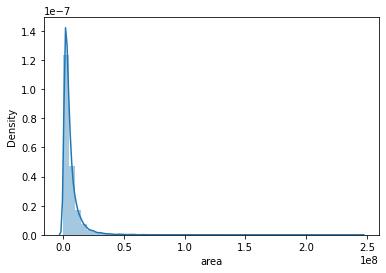

In [36]:
sns.distplot(gdf['area'])

In [37]:
gdf['no_of_pixels'] = gdf['area'] / 900

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


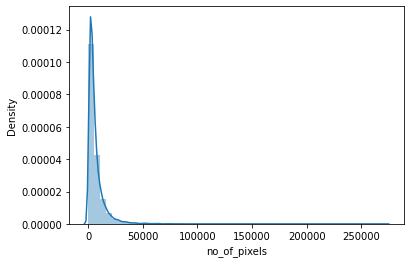

In [38]:
sns.distplot(gdf['no_of_pixels'])

In [39]:
gdf.describe()

,HDI,unique code,SHAPE_Leng,SHAPE_Area,area,no_of_pixels
count,18984.000000,1.898400e+04,18984.000000,1.898400e+04,1.898400e+04,18984.000000
mean,0.407828,2.957076e+15,10738.594240,6.056185e+06,6.056139e+06,6729.043671
std,0.104890,8.142506e+11,5856.302005,7.395854e+06,7.395765e+06,8217.516707
min,0.006050,2.955505e+15,290.597767,4.939737e+03,4.939737e+03,5.488597
25%,0.343673,2.956505e+15,6685.817782,2.050699e+06,2.050699e+06,2278.554224
50%,0.421940,2.957106e+15,9369.445562,3.832122e+06,3.832122e+06,4257.912985
75%,0.481440,2.957706e+15,13259.717136,7.188178e+06,7.188178e+06,7986.863992
max,0.723130,2.958406e+15,96341.233422,2.444253e+08,2.444253e+08,271583.643362


In [41]:
# Import landsat 8 image collection
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
Map = geemap.Map()

In [44]:
gdf.loc[gdf['unique code'] == 2958205599624019]

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry,area,no_of_pixels
3997,0.41889,chikkaballapura,sidlaghatta,sonaganahalli,sadali,2958205599624019,10783.401072,4.528551e+06,"POLYGON ((7.29988 13.46208, 7.29859 13.45922, ...",4.528551e+06,5031.723488


In [45]:
def check_status(task_id):
    i = 0
    while True:
        if i%30000 == 0:
            status = ee.data.getTaskStatus(task_id)[0]['state']

            print('Status: ', status)
        i+=1
        if status.lower() == 'failed' or status.lower() == 'completed':
            break

In [46]:
def get_images(geometry, id):
    
    features = []

    for p in range(len(geometry)):
        #g = ee.Geometry.Polygon(cords)
        #feature = ee.Feature(g)
        f = ee.Feature(gpd.GeoSeries(geometry[p]).__geo_interface__['features'][0])
        features.append(f)
    
    # convert list of features into feature collection
    geometry = ee.FeatureCollection(features)
    
    filtered_collection = l8.filterBounds(geometry)\
                            .filterDate('2015-01-01','2016-12-31')\
                            .filterMetadata('CLOUD_COVER','less_than',1)\
                            .select('B[2-7]')
    #print(filtered_collection.size().getInfo())

    image = filtered_collection.median()
    clipped_image = image.clip(geometry).toFloat()

    Map.centerObject(geometry)

    Map.addLayer(clipped_image)

    task = ee.batch.Export.image.toDrive(clipped_image, 
                                        description = id,
                                        folder = 'Landsat',                                    
                                        region = geometry.geometry(),
                                        scale = 30,
                                        crs = 'EPSG:4326'                                    
                                        )
    task.start()

    return task.id


In [ ]:
from tqdm import tqdm
for i in tqdm(gdf['unique code'].iloc[5123:8200]):
    #print(i)
    geometry = gdf['geometry'][(gdf['unique code'] == i)]
    #print(geometry[0])
    task_id = get_images(geometry.values, str(i))
    #check_status(task_id)


 20%|██        | 630/3077 [2:01:13<8:26:53, 12.43s/it]

In [47]:
import glob
all_files = glob.glob('/content/drive/My Drive/Landsat1/*.tif')
len(all_files)

1123

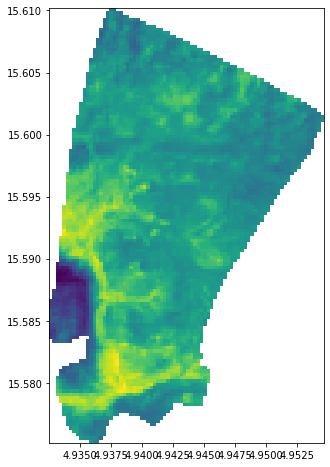

In [29]:
# visualizing the image - RGB bands need to be manually named using ColorInterp to view RGB image
import matplotlib.pyplot as plt
from rasterio.plot import show
plt.figure(figsize=(10,8))
# the file has been downloaded from drive to show here
image = rasterio.open('/content/drive/My Drive/Landsat/2955605446598724.tif')
show(image, adjust='linear')
plt.show()

In [32]:
image.read().shape

(6, 130, 82)